In [630]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
%matplotlib inline

In [535]:
df = pd.read_csv('housing.csv')
df.head()

,address,bed_bath,more_info,price,status,zip_code
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,"$1,299,000",Condo For Sale,60601
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,"$324,900",Condo For Sale,60601
2,NaN,NaN,NaN,NaN,NaN,60601
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,"$1,099,000",Condo For Sale,60601
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,"$567,770",Condo For Sale,60601


In [536]:
df.shape

(7468, 6)

In [537]:
df.isnull().sum()

address       280
bed_bath      280
more_info     280
price        2542
status        280
zip_code        0
dtype: int64

In [538]:
df[df['address'].isnull()]
'''280 rows of address/bed_bath/more_info/status is null. We really can't base anything off the zip code, 
so we will drop these rows'''

"280 rows of address/bed_bath/more_info/status is null. We really can't base anything off the zip code, \nso we will drop these rows"

In [539]:
df = df[df['address'].notnull()]
df.isnull().sum()

address         0
bed_bath        0
more_info       0
price        2262
status          0
zip_code        0
dtype: int64

In [540]:
df[df['price'].isnull()]['status'].value_counts()

Pre-Foreclosure              1182
Foreclosed                    530
Pre-Foreclosure (Auction)     395
Auction                       121
Foreclosure                    32
House For Sale                  1
Make Me Move®                   1
Name: status, dtype: int64

In [541]:
df.loc[(df['price'].isnull())&(df['status'] == 'House For Sale'), ['address','bed_bath','more_info','price','status','zip_code']]

,address,bed_bath,more_info,price,status,zip_code
1884,"1515 E 52nd Pl STE 210, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1515-E-52nd-...,NaN,House For Sale,60615


In [542]:
df.loc[df['price'].isnull() & (df['status'] == 'House For Sale'), 'more_info'].values

array([ 'http://www.zillow.com/homedetails/1515-E-52nd-Pl-STE-210-Chicago-IL-60615/2098853430_zpid/'], dtype=object)

In [543]:
df.loc[(df['price'].isnull()) & (df['status'] == 'Make Me Move®'), 'more_info'].values

array([ 'http://www.zillow.com/homedetails/8136-W-Summerdale-Ave-Chicago-IL-60656/3581759_zpid/'], dtype=object)

In [544]:
df.loc[(df['price'].isnull()) & (df['status'] == 'Pre-Foreclosure'), 'more_info'].values

array(['http://www.zillow.com/homedetail/AuthRequired.htm?r=pfc&zpid=126074971',
       'http://www.zillow.com/homedetail/AuthRequired.htm?r=pfc&zpid=126059118',
       'http://www.zillow.com/homedetail/AuthRequired.htm?r=pfc&zpid=128635066',
       ...,
       'http://www.zillow.com/homedetail/AuthRequired.htm?r=pfc&zpid=128460478',
       'http://www.zillow.com/homedetail/AuthRequired.htm?r=pfc&zpid=128631954',
       'http://www.zillow.com/homedetail/AuthRequired.htm?r=pfc&zpid=127009323'], dtype=object)

In [545]:
df.shape

(7188, 6)

In [546]:
(2262+280)/7188.0

0.3536449638286032

**I am considering dropping all the NULL entries (2,262) of price as they are either Foreclosed or in the process of doing so. The foreclosed price is set by the bank and is made up of a number of factors(Broker's Price Opinion, Oustanding Amount Owed, Late Penalties, Auction Bids, Discounted Prices, etc.) depending on the timing of the foreclosure process, which we do not have information on. Pre-foreclosed listings are hidden and the user needs to be signed in in order to view it, and are not necessarily listed for sale. Pre-foreclosure is the grace period (~90 days) when the borrower defaults on mortgage payments, and there are many options for the borrower (repaying the mortgages, short selling, negotiating with bank etc.). The listing prices would be 'Zestimates', which are Zillow-predicted prices when the property forecloses, which would not be an accurate market valuation.**

**We can obtain more samples through our own webscraping**

In [547]:
df = df[df['price'].notnull()]

In [548]:
df.shape

(4926, 6)

In [549]:
df.isnull().sum()

address      0
bed_bath     0
more_info    0
price        0
status       0
zip_code     0
dtype: int64

In [550]:
df['status'].value_counts()

Condo For Sale        1943
House For Sale        1335
Apartment For Sale     476
Lot/Land For Sale      250
Auction                207
Foreclosure            200
For Sale by Owner      166
New Construction       143
Townhouse For Sale     109
Make Me Move®           68
Co-op For Sale          20
Coming Soon              9
Name: status, dtype: int64

In [551]:
df = df[(df['status'] != 'Auction') & (df['status'] != 'Foreclosure')]
df['status'].value_counts()
#We remove the rest of the Foreclosed and Auctioned properties

Condo For Sale        1943
House For Sale        1335
Apartment For Sale     476
Lot/Land For Sale      250
For Sale by Owner      166
New Construction       143
Townhouse For Sale     109
Make Me Move®           68
Co-op For Sale          20
Coming Soon              9
Name: status, dtype: int64

In [552]:
df.shape

(4519, 6)

<h1 align='center'>Webscraping</h1>

In [100]:
#TESTING SECTION
# import requests
# from bs4 import BeautifulSoup

# #use df.drop_duplicates if you scrape additional Chicago data
# website = 'https://www.zillow.com/homes/for_sale/Chicago-IL/fsba,fsbo,new_lt/17426_rid/42.032974,-87.495461,41.633407,-87.967873_rect/10_zm/%s_p/0_mmm/'

# r = requests.get(website)

# # with open('chicago_houses.html', 'w') as f:
# #     f.write(r.content)

# # with open('chicago_houses.html', 'r') as f:
# soup = BeautifulSoup(r.content,'lxml')

In [141]:
import time
import urlparse
rg = range(3,11)
for rge in rg:
    website = 'https://www.zillow.com/homes/for_sale/Chicago-IL/fsba,fsbo,new_lt/17426_rid/42.032974,-87.495461,41.633407,-87.967873_rect/10_zm/%s_p/0_mmm/' % rge
    r = requests.get(website)
    soup = BeautifulSoup(r.content,'lxml')
    base = 'https://www.zillow.com'
    data = {}
    housing_cards = soup.find_all('div',{'class':'zsg-photo-card-content zsg-aspect-ratio-content'})
    for i, card in enumerate(housing_cards):
        data[i] = {}
        address = card.find('span',{'class':'zsg-photo-card-address'})
        if len(address) == 0 or address is None:
            data[i]['address'] = 'MISSING'
        else:
            data[i]['address'] = address.text
        bed_bath = card.find('span',{'class':'zsg-photo-card-info'})
        if len(bed_bath) == 0 or bed_bath is None:
            data[i]['bed_bath'] = 'MISSING'
        else:
            data[i]['bed_bath'] = bed_bath.text.encode('ascii', 'ignore')
        price = card.find('span',{'class':'zsg-photo-card-price'})
        if price is None or len(price) == 0:
            data[i]['price'] = 'MISSING'
        else:
            data[i]['price'] = price.text
        link = card.find('a', href=True)
        data[i]['link'] = urlparse.urljoin(base,link.get('href'))
        status = card.find('span',{'class':'zsg-photo-card-status'})
        if len(status) == 0 or status is None:
            data[i]['status'] = 'MISSING'
        else:
            data[i]['status'] = status.text.encode('ascii','ignore')
            time.sleep(3)
    ds = pd.DataFrame().from_dict(data, orient = 'index')
    ds.to_csv('test%s.csv' % rge, index = False)
        

#this is the script to scrape all the columns from the original dataframe except for the ZIP code for the listings
#on pages 3 - 10 and save them as CSVs called 'test3.csv, test4.csv etc'. I had already scraped page 2 and saved it to
#'test.csv', and the code for it was written over by the code above.

In [144]:
testdf = pd.read_csv('test.csv')
test3df = pd.read_csv('test3.csv')
test4df = pd.read_csv('test4.csv')
test5df = pd.read_csv('test5.csv')
test6df = pd.read_csv('test6.csv')
test7df = pd.read_csv('test7.csv')
test8df = pd.read_csv('test8.csv')
test9df = pd.read_csv('test9.csv')
test10df = pd.read_csv('test10.csv')
#We read the scraped CSVs into DataFrames.

In [214]:
dataframes = [testdf, test3df, test4df, test5df, test6df, test7df, test8df, test9df, test10df]

In [215]:
for x in dataframes:
    x.rename(columns = {'link': 'more_info'}, inplace = True)
testdf.head()
#we rename the link column to more_info so it matches the original dataframe

,status,price,bed_bath,more_info,address,zip_code
0,Condo For Sale,"$259,000","3 bds 2 ba 1,300 sqft",https://www.zillow.com/homedetails/2613-S-Lowe...,"2613 S Lowe Ave # 1, Chicago, IL",60616
1,Condo For Sale,"$124,750",1 bd 2 ba 800 sqft,https://www.zillow.com/homedetails/7433-N-Clar...,"7433 N Claremont Ave # G, Chicago, IL",60645
2,Condo For Sale,"$188,000",1 bd 1 ba 950 sqft,https://www.zillow.com/homedetails/2309-W-Ains...,"2309 W Ainslie St # 2, Chicago, IL",60625
3,Condo For Sale,"$264,900",1 bd 1 ba 850 sqft,https://www.zillow.com/homedetails/535-N-Michi...,"535 N Michigan Ave APT 2009, Chicago, IL",60611
4,Condo For Sale,"$799,000",3 bds 3 ba -- sqft,https://www.zillow.com/homedetails/3735-N-Wilt...,"3735 N Wilton Ave APT 1S, Chicago, IL",60613


In [216]:
dframes = [test3df, test4df, test5df, test6df, test7df, test8df, test9df, test10df]
for dframe in dframes:
    dframe['zip_code'] = dframe['more_info'].apply(lambda x: x.split('IL-')[1][:5])
#We add back the zip_code column by grabbing it from the URL link in the more_info column

In [553]:
mergeframes = [df, test3df, test4df, test5df, test6df, test7df, test8df, test9df, test10df]
df1 = pd.concat(mergeframes)
df1.isnull().sum()

address      0
bed_bath     0
more_info    0
price        0
status       0
zip_code     0
dtype: int64

In [554]:
df1.shape

(4727, 6)

In [555]:
df1.head()

,address,bed_bath,more_info,price,status,zip_code
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,"$1,299,000",Condo For Sale,60601
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,"$324,900",Condo For Sale,60601
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,"$1,099,000",Condo For Sale,60601
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,"$567,770",Condo For Sale,60601
5,"155 N Harbor Dr # 1212-13, Chicago, IL","3 bds · 3 ba · 2,367 sqft",http://www.zillow.com/homedetails/155-N-Harbor...,"$1,350,000",Condo For Sale,60601


In [556]:
df1.dtypes

address      object
bed_bath     object
more_info    object
price        object
status       object
zip_code     object
dtype: object

<h1 align='center'>Data Cleaning</h1>

In [557]:
def money(values):
    values = values.replace('$','')
    values = values.replace(',','')
    values = values.replace('+','')
    return float(values)
# df1['price'] = df1['price'].apply(money)
df1.reset_index(inplace = True)
#We first reset the index

In [558]:
df1 = df1[df1['status'] != 'Auction']

In [559]:
df1['price'] = df1['price'].apply(money)

In [560]:
df1['bed_bath'] = df1['bed_bath'].apply(lambda x: x.replace('bd','X'))

In [561]:
df1['beds'] = df1['bed_bath'].apply(lambda x: x.split('X')[0])

In [562]:
df1[df1['beds'].str.contains('Studio')]

,index,address,bed_bath,more_info,price,status,zip_code,beds
88,100,"400 E Randolph St APT 1311, Chicago, IL",Studio · 1 ba · 650 sqft,http://www.zillow.com/homedetails/400-E-Randol...,320000.0,Condo For Sale,60601,Studio · 1 ba · 650 sqft
104,117,"450 E Waterside Dr UNIT 907, Chicago, IL",Studio · 1 ba · 650 sqft,http://www.zillow.com/homedetails/450-E-Waters...,300000.0,Condo For Sale,60601,Studio · 1 ba · 650 sqft
399,439,"40 E 9th St # GU-39, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/40-E-9th-St-...,38000.0,House For Sale,60605,Studio · -- ba · -- sqft
400,440,"40 E 9th St # GU-23, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/40-E-9th-St-...,38000.0,House For Sale,60605,Studio · -- ba · -- sqft
437,479,"41 E 8th St # P-34, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/41-E-8th-St-...,34000.0,House For Sale,60605,Studio · -- ba · -- sqft
452,515,"1250 S Michigan Ave # P-222, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1250-S-Michi...,30000.0,House For Sale,60605,Studio · -- ba · -- sqft
468,533,"740 S Federal St APT 802, Chicago, IL",Studio · 1 ba · 658 sqft,http://www.zillow.com/homedetails/740-S-Federa...,124900.0,Condo For Sale,60605,Studio · 1 ba · 658 sqft
469,534,"633 S Plymouth Ct APT 1208, Chicago, IL","Studio · 1 ba · 1,100 sqft",http://www.zillow.com/homedetails/633-S-Plymou...,229900.0,Condo For Sale,60605,"Studio · 1 ba · 1,100 sqft"
577,668,"611 S Wells St APT 710, Chicago, IL",Studio · 1 ba · 524 sqft,http://www.zillow.com/homedetails/611-S-Wells-...,211000.0,Condo For Sale,60607,Studio · 1 ba · 524 sqft
601,694,"800 S Wells St # M44, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/800-S-Wells-...,50000.0,For Sale by Owner,60607,Studio · -- ba · -- sqft


In [563]:
df1.loc[df1['beds'].str.contains('Studio'), 'beds'] = 0

In [564]:
df1['more_info'][209]

'http://www.zillow.com/homedetails/8-W-Monroe-St-PL-5-Chicago-IL-60603/2096002760_zpid/'

In [565]:
df1['more_info'][400]

'http://www.zillow.com/homedetails/40-E-9th-St-GU-23-Chicago-IL-60605/2095274652_zpid/'

In [566]:
#These links above are actually for parking spaces, we will attempt to remove them from the dataset

In [567]:
df1['status'].value_counts()

Condo For Sale        2059
House For Sale        1379
Apartment For Sale     497
Lot/Land For Sale      250
For Sale by Owner      167
New Construction       156
Townhouse For Sale     112
Make Me Move®           68
Co-op For Sale          20
Coming Soon              9
Name: status, dtype: int64

In [568]:
df1.loc[df1['status'] == 'Lot/Land For Sale'].describe()

,index,price
count,250.000000,2.500000e+02
mean,3060.704000,1.820857e+05
std,1859.321481,4.751539e+05
min,236.000000,1.000000e+03
25%,1449.500000,1.700000e+04
50%,2947.500000,3.500000e+04
75%,4099.500000,1.230000e+05
max,7199.000000,3.449000e+06


In [569]:
df1 = df1[df1['status'] != 'Lot/Land For Sale']
df1.shape

(4467, 8)

In [570]:
df1 = df1.drop_duplicates(['address']).reset_index(drop = True)

In [571]:
df1.shape

(3911, 8)

In [572]:
df1[df1['price'] == 38000]

,index,address,bed_bath,more_info,price,status,zip_code,beds
205,439,"40 E 9th St # GU-39, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/40-E-9th-St-...,38000.0,House For Sale,60605,0
206,440,"40 E 9th St # GU-23, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/40-E-9th-St-...,38000.0,House For Sale,60605,0
2409,4485,"5733 S Ada St, Chicago, IL","5 Xs · 2 ba · 3,250 sqft",http://www.zillow.com/homedetails/5733-S-Ada-S...,38000.0,House For Sale,60636,5


In [573]:
df1.drop([205,206], inplace = True)
#dropped two parking lots classified as House For Sale

In [574]:
pd.to_numeric(df1['beds'])

ValueError: Unable to parse string "-- " at position 218

In [575]:
df1[df1['beds'] == '-- ']

,index,address,bed_bath,more_info,price,status,zip_code,beds
220,454,"801 S Plymouth Ct # P209, Chicago, IL",-- Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/801-S-Plymou...,45000.0,House For Sale,60605,--
721,1269,"405 N Wabash Ave # D55, Chicago, IL",-- Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/405-N-Wabash...,55000.0,House For Sale,60611,--
811,1380,"2516-20 W Harrison St, Chicago, IL",-- Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/2516-20-W-Ha...,2985000.0,Apartment For Sale,60612,--
825,1412,"513 N Albany Ave # 0, Chicago, IL",-- Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/513-N-Albany...,28000.0,House For Sale,60612,--
944,1580,"3660 N Lake Shore Dr APT 4209, Chicago, IL",-- Xs · 1 ba · -- sqft,http://www.zillow.com/homedetails/3660-N-Lake-...,175000.0,Condo For Sale,60613,--
970,1608,"3844 N Clark St # P-15, Chicago, IL",-- Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/3844-N-Clark...,25000.0,Make Me Move®,60613,--
1515,2534,"8547 S May St, Chicago, IL",-- Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/8547-S-May-S...,215000.0,Apartment For Sale,60620,--
1697,2865,"2808 S Sawyer Ave # SIGLE-FAM, Chicago, IL",-- Xs · 3 ba · -- sqft,http://www.zillow.com/homedetails/2808-S-Sawye...,55000.0,House For Sale,60623,--
2059,3622,"6557 S Maplewood Ave, Chicago, IL",-- Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/6557-S-Maple...,239900.0,Apartment For Sale,60629,--
2073,3643,"6156 S Washtenaw Ave, Chicago, IL",-- Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/6156-S-Washt...,365000.0,Apartment For Sale,60629,--


In [576]:
df1 = df1[df1['beds'] != '-- ']

In [577]:
df1[df1['beds'] == '6,800 sqft lot']

,index,address,bed_bath,more_info,price,status,zip_code,beds
2161,3828,"6209 N Nordica Ave, Chicago, IL","6,800 sqft lot",http://www.zillow.com/homedetails/6209-N-Nordi...,299900.0,For Sale by Owner,60631,"6,800 sqft lot"


In [578]:
df1 = df1[df1['beds'] != '6,800 sqft lot']

In [579]:
df1[df1['beds'].str.contains('sqft') == True]

,index,address,bed_bath,more_info,price,status,zip_code,beds
2428,4534,"6409 S Racine Ave, Chicago, IL","3,135 sqft lot",http://www.zillow.com/homedetails/6409-S-Racin...,5000.0,For Sale by Owner,60636,"3,135 sqft lot"


In [580]:
df1 = df1[df1['beds'] != '3,135 sqft lot']

In [581]:
df1['beds_int'] = pd.to_numeric(df1['beds'])

In [582]:
df1.dtypes

index          int64
address       object
bed_bath      object
more_info     object
price        float64
status        object
zip_code      object
beds          object
beds_int       int64
dtype: object

In [583]:
df1.drop('beds', axis = 1, inplace = True)

In [584]:
df1.dtypes

index          int64
address       object
bed_bath      object
more_info     object
price        float64
status        object
zip_code      object
beds_int       int64
dtype: object

In [585]:
df1['baths'] = df1['bed_bath'].apply(lambda x: x.split(' ba')[0][-1])

In [586]:
df1[df1['baths'] == '-']

,index,address,bed_bath,more_info,price,status,zip_code,beds_int,baths
243,479,"41 E 8th St # P-34, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/41-E-8th-St-...,34000.0,House For Sale,60605,0,-
258,515,"1250 S Michigan Ave # P-222, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1250-S-Michi...,30000.0,House For Sale,60605,0,-
335,694,"800 S Wells St # M44, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/800-S-Wells-...,50000.0,For Sale by Owner,60607,0,-
361,723,"222 S Racine Ave # P-11, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/222-S-Racine...,39900.0,House For Sale,60607,0,-
363,727,"235 W Van Buren St # P387T, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/235-W-Van-Bu...,39800.0,House For Sale,60607,0,-
381,758,"1224 W Van Buren St, Chicago, IL","2 Xs · -- ba · 1,043 sqft",http://www.zillow.com/homedetails/1224-W-Van-B...,270000.0,House For Sale,60607,2,-
419,802,"1000 W 15th St # GU106, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1000-W-15th-...,30000.0,House For Sale,60608,0,-
461,893,"2979 S Archer Ave UNIT 1, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/2979-S-Arche...,799900.0,Apartment For Sale,60608,0,-
469,902,"1942 S Carpenter St, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1942-S-Carpe...,1500000.0,Apartment For Sale,60608,0,-
486,923,"3300 S Bell Ave, Chicago, IL",7 Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/3300-S-Bell-...,235000.0,Condo For Sale,60608,7,-


In [587]:
df1[df1['address'].str.contains('P-')]

,index,address,bed_bath,more_info,price,status,zip_code,beds_int,baths
243,479,"41 E 8th St # P-34, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/41-E-8th-St-...,34000.0,House For Sale,60605,0,-
258,515,"1250 S Michigan Ave # P-222, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1250-S-Michi...,30000.0,House For Sale,60605,0,-
361,723,"222 S Racine Ave # P-11, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/222-S-Racine...,39900.0,House For Sale,60607,0,-
3680,7222,"125 S Jefferson St # P-98, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/125-S-Jeffer...,32000.0,House For Sale,60661,0,-


In [588]:
df1.drop([241,256,359,3678],inplace = True)
#drop more parking spots

In [589]:
df1[df1['baths'] == '-']

,index,address,bed_bath,more_info,price,status,zip_code,beds_int,baths
243,479,"41 E 8th St # P-34, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/41-E-8th-St-...,34000.0,House For Sale,60605,0,-
258,515,"1250 S Michigan Ave # P-222, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1250-S-Michi...,30000.0,House For Sale,60605,0,-
335,694,"800 S Wells St # M44, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/800-S-Wells-...,50000.0,For Sale by Owner,60607,0,-
361,723,"222 S Racine Ave # P-11, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/222-S-Racine...,39900.0,House For Sale,60607,0,-
363,727,"235 W Van Buren St # P387T, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/235-W-Van-Bu...,39800.0,House For Sale,60607,0,-
381,758,"1224 W Van Buren St, Chicago, IL","2 Xs · -- ba · 1,043 sqft",http://www.zillow.com/homedetails/1224-W-Van-B...,270000.0,House For Sale,60607,2,-
419,802,"1000 W 15th St # GU106, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1000-W-15th-...,30000.0,House For Sale,60608,0,-
461,893,"2979 S Archer Ave UNIT 1, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/2979-S-Arche...,799900.0,Apartment For Sale,60608,0,-
469,902,"1942 S Carpenter St, Chicago, IL",Studio · -- ba · -- sqft,http://www.zillow.com/homedetails/1942-S-Carpe...,1500000.0,Apartment For Sale,60608,0,-
486,923,"3300 S Bell Ave, Chicago, IL",7 Xs · -- ba · -- sqft,http://www.zillow.com/homedetails/3300-S-Bell-...,235000.0,Condo For Sale,60608,7,-


In [590]:
df1['more_info'][333]
#boat

'http://www.zillow.com/community/university-village-row-homes/2096071519_zpid/'

In [591]:
df1['more_info'][467]
#multi unit

'http://www.zillow.com/homedetails/3210-S-Leavitt-St-Chicago-IL-60608/3879249_zpid/'

In [592]:
df1.drop([417,648], inplace = True)

In [593]:
df1[df1['baths'] == '-'].count()

index        73
address      73
bed_bath     73
more_info    73
price        73
status       73
zip_code     73
beds_int     73
baths        73
dtype: int64

In [594]:
df1 = df1[df1['baths'] != '-']

In [595]:
df1['baths_int'] = pd.to_numeric(df1['baths'])

In [596]:
df1.drop(['baths'], axis = 1, inplace = True)

In [597]:
df1['bed_bath'][1]

'1 X \xc2\xb7 1 ba \xc2\xb7 850 sqft'

In [598]:
df1['bed_bath'][1].split('\xc2\xb7 ')[2].split(' sqft')[0]

'850'

In [599]:
df1['bed_bath'] = df1['bed_bath'].apply(lambda x: x.replace(' ','|'))

In [601]:
df1.head()

,index,address,bed_bath,more_info,price,status,zip_code,beds_int,baths_int
0,0,"360 E Randolph St # 601-602, Chicago, IL","3|Xs|·|4|ba|·|2,700|sqft",http://www.zillow.com/homedetails/360-E-Randol...,1299000.0,Condo For Sale,60601,3,4
1,1,"8 E Randolph St UNIT 1006, Chicago, IL",1|X|·|1|ba|·|850|sqft,http://www.zillow.com/homedetails/8-E-Randolph...,324900.0,Condo For Sale,60601,1,1
2,3,"340 E Randolph St APT 704, Chicago, IL","2|Xs|·|3|ba|·|1,902|sqft",http://www.zillow.com/homedetails/340-E-Randol...,1099000.0,Condo For Sale,60601,2,3
3,4,"420 E Waterside Dr UNIT 310, Chicago, IL","2|Xs|·|3|ba|·|1,500|sqft",http://www.zillow.com/homedetails/420-E-Waters...,567770.0,Condo For Sale,60601,2,3
4,5,"155 N Harbor Dr # 1212-13, Chicago, IL","3|Xs|·|3|ba|·|2,367|sqft",http://www.zillow.com/homedetails/155-N-Harbor...,1350000.0,Condo For Sale,60601,3,3


In [603]:
df1['sqrt'] = df1['bed_bath'].apply(lambda x: x.split('|')[-2])

In [604]:
df1.head()

,index,address,bed_bath,more_info,price,status,zip_code,beds_int,baths_int,sqrt
0,0,"360 E Randolph St # 601-602, Chicago, IL","3|Xs|·|4|ba|·|2,700|sqft",http://www.zillow.com/homedetails/360-E-Randol...,1299000.0,Condo For Sale,60601,3,4,"2,700"
1,1,"8 E Randolph St UNIT 1006, Chicago, IL",1|X|·|1|ba|·|850|sqft,http://www.zillow.com/homedetails/8-E-Randolph...,324900.0,Condo For Sale,60601,1,1,850
2,3,"340 E Randolph St APT 704, Chicago, IL","2|Xs|·|3|ba|·|1,902|sqft",http://www.zillow.com/homedetails/340-E-Randol...,1099000.0,Condo For Sale,60601,2,3,"1,902"
3,4,"420 E Waterside Dr UNIT 310, Chicago, IL","2|Xs|·|3|ba|·|1,500|sqft",http://www.zillow.com/homedetails/420-E-Waters...,567770.0,Condo For Sale,60601,2,3,"1,500"
4,5,"155 N Harbor Dr # 1212-13, Chicago, IL","3|Xs|·|3|ba|·|2,367|sqft",http://www.zillow.com/homedetails/155-N-Harbor...,1350000.0,Condo For Sale,60601,3,3,"2,367"


In [605]:
df1['sqrt'] = df1['sqrt'].apply(lambda x: x.replace(',',''))

In [606]:
df1[df1['sqrt'] == '--']

,index,address,bed_bath,more_info,price,status,zip_code,beds_int,baths_int,sqrt
29,33,"155 N Harbor Dr APT 3814, Chicago, IL",1|X|·|1|ba|·|--|sqft,http://www.zillow.com/homedetails/155-N-Harbor...,289000.0,Condo For Sale,60601,1,1,--
91,111,"222 N Columbus Dr APT 3106, Chicago, IL",1|X|·|1|ba|·|--|sqft,http://www.zillow.com/homedetails/222-N-Columb...,249500.0,Condo For Sale,60601,1,1,--
115,139,"6 N Michigan Ave UNIT 1608, Chicago, IL",2|Xs|·|3|ba|·|--|sqft,http://www.zillow.com/homedetails/6-N-Michigan...,989900.0,Condo For Sale,60602,2,3,--
176,405,"1464 S Michigan Ave APT 1004, Chicago, IL",2|Xs|·|2|ba|·|--|sqft,http://www.zillow.com/homedetails/1464-S-Michi...,355000.0,Condo For Sale,60605,2,2,--
182,412,"124 W Polk St APT 506, Chicago, IL",1|X|·|1|ba|·|--|sqft,http://www.zillow.com/homedetails/124-W-Polk-S...,275000.0,Condo For Sale,60605,1,1,--
218,452,"1255 S State St UNIT 1318, Chicago, IL",2|Xs|·|1|ba|·|--|sqft,http://www.zillow.com/homedetails/1255-S-State...,319000.0,Condo For Sale,60605,2,1,--
245,487,"621 S Plymouth Ct APT 304, Chicago, IL",1|X|·|1|ba|·|--|sqft,http://www.zillow.com/homedetails/621-S-Plymou...,225000.0,Condo For Sale,60605,1,1,--
251,507,"600 S Dearborn St APT 508, Chicago, IL",1|X|·|1|ba|·|--|sqft,http://www.zillow.com/homedetails/600-S-Dearbo...,224900.0,Condo For Sale,60605,1,1,--
262,520,"1464 S Michigan Ave APT 1101, Chicago, IL",2|Xs|·|2|ba|·|--|sqft,http://www.zillow.com/homedetails/1464-S-Michi...,349724.0,Condo For Sale,60605,2,2,--
281,540,"1515 S Prairie Ave UNIT 701, Chicago, IL",1|X|·|2|ba|·|--|sqft,http://www.zillow.com/homedetails/1515-S-Prair...,335000.0,Condo For Sale,60605,1,2,--


In [607]:
df1['sqrt'] = df1['sqrt'].apply(lambda x:x.replace('+',''))

In [608]:
dfnosqft = df1
#This dataframe contains more rows, but we won't be using the square feet feature

In [609]:
dfsqft = df1.loc[df1['sqrt'] != '--', ['address','more_info','price','status','zip_code','beds_int','baths_int','sqrt']]
dfsqft.shape
#This dataframe contains only rows that don't have '--' as square feet values. 

(2998, 8)

In [610]:
dfsqft['sqrtint'] = pd.to_numeric(dfsqft['sqrt'])

In [611]:
dfsqft.dtypes

address       object
more_info     object
price        float64
status        object
zip_code      object
beds_int       int64
baths_int      int64
sqrt          object
sqrtint        int64
dtype: object

In [614]:
pd.options.display.float_format = '{:20,.2f}'.format
dfsqft['price'].describe()

count               2,998.00
mean              521,430.92
std               828,383.46
min                 5,000.00
25%               179,000.00
50%               319,900.00
75%               549,000.00
max            12,950,000.00
Name: price, dtype: float64

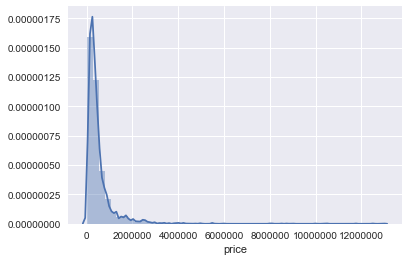

In [624]:
sns.plt.ticklabel_format(style='plain', axis='x',useOffset=False)
sns.distplot(dfsqft['price'])

In [625]:
#We will use the median as the split between 'high' and 'low' prices, since there a large values that bring the mean up

In [626]:
dfsqft['ishigh'] = dfsqft['price'].apply(lambda x: 1 if x > 319900 else 0)

In [627]:
dfsqft['ishigh'].value_counts()

0    1507
1    1491
Name: ishigh, dtype: int64

In [642]:
dfsqft.head()

,address,more_info,price,status,zip_code,beds_int,baths_int,sqrt,sqrtint,ishigh
0,"360 E Randolph St # 601-602, Chicago, IL",http://www.zillow.com/homedetails/360-E-Randol...,"1,299,000.00",Condo For Sale,60601,3,4,2700,2700,1
1,"8 E Randolph St UNIT 1006, Chicago, IL",http://www.zillow.com/homedetails/8-E-Randolph...,"324,900.00",Condo For Sale,60601,1,1,850,850,1
2,"340 E Randolph St APT 704, Chicago, IL",http://www.zillow.com/homedetails/340-E-Randol...,"1,099,000.00",Condo For Sale,60601,2,3,1902,1902,1
3,"420 E Waterside Dr UNIT 310, Chicago, IL",http://www.zillow.com/homedetails/420-E-Waters...,"567,770.00",Condo For Sale,60601,2,3,1500,1500,1
4,"155 N Harbor Dr # 1212-13, Chicago, IL",http://www.zillow.com/homedetails/155-N-Harbor...,"1,350,000.00",Condo For Sale,60601,3,3,2367,2367,1


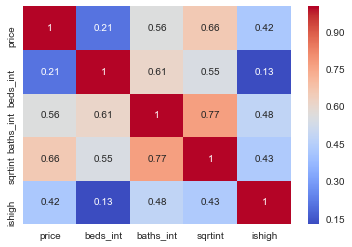

In [644]:
sns.heatmap(dfsqft.corr(), cmap = 'coolwarm', annot = True)

In [633]:
features = ['beds_int','baths_int','sqrtint']
y = dfsqft['ishigh']
log_reg = LogisticRegression()
hyperparameters = {'penalty':['l1','l2'],
                  'C': [0.1, 1.0, 10]}
grid_search = GridSearchCV(log_reg, hyperparameters, verbose = 10)
grid_search.fit(dfsqft[features], y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.736000, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.784785, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.764765, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.755000, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.783784, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.758759, total=   0.0s
[CV] penalty=l1, C=1.0 ...............................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1.0, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [634]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [636]:
grid_search.best_estimator_.fit(dfsqft[features],y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [637]:
grid_search.best_estimator_.score(dfsqft[features],y)

0.7888592394929953

In [638]:
predictions = grid_search.best_estimator_.predict(dfsqft[features])

In [640]:
print metrics.classification_report(y, predictions)

             precision    recall  f1-score   support

          0       0.77      0.83      0.80      1507
          1       0.81      0.75      0.78      1491

avg / total       0.79      0.79      0.79      2998



In [641]:
print pd.DataFrame(metrics.confusion_matrix(y, predictions), 
                   columns=['Predicted Low', 'Predicted High'],
                   index=['Is Low', 'Is High'])

         Predicted Low  Predicted High
Is Low            1245             262
Is High            371            1120


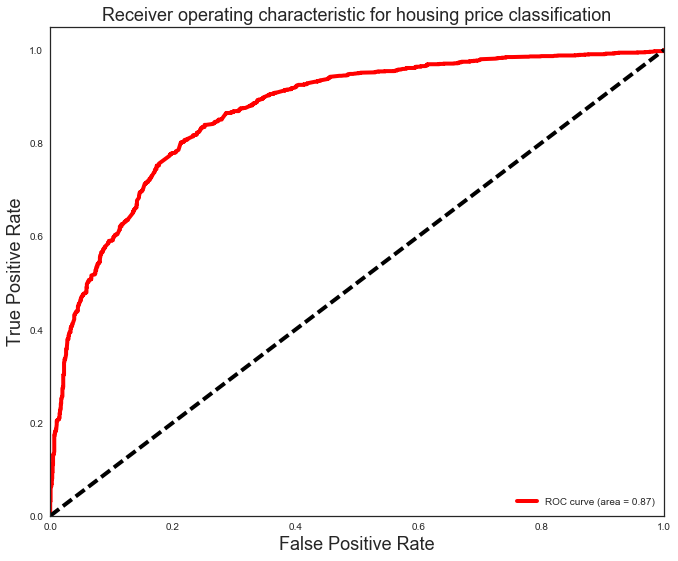

In [650]:
plt.style.use('seaborn-white')

Y_score = grid_search.best_estimator_.decision_function(dfsqft[features])

FPR = dict()
TPR = dict()
ROC_AUC = dict() # {}

# For class 1, find the area under the curve

#print metrics.roc_curve(y, Y_score)

FPR[1], TPR[1], _ = metrics.roc_curve(y, Y_score)
ROC_AUC[1] = metrics.auc(FPR[1], TPR[1])


# Plot of a ROC curve for class 1 (high price)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4, color = 'r')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for housing price classification', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [651]:
#Now we will test with kNN
from sklearn.preprocessing import StandardScaler
x = dfsqft[features]
standard_scale = StandardScaler()
standard_scale.fit(x)
standardized_x = standard_scale.transform(x)

In [652]:
X_train, X_test, y_train, y_test = train_test_split(standardized_x, y, test_size = 0.3)

In [655]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knn.score(X_train,y_train)

0.83555767397521452

In [657]:
predictions = knn.predict(X_train)
print metrics.classification_report(y_train, predictions)

             precision    recall  f1-score   support

          0       0.82      0.87      0.84      1071
          1       0.85      0.80      0.83      1027

avg / total       0.84      0.84      0.84      2098



In [665]:
cmatrix = np.array(metrics.confusion_matrix(y_train, predictions, labels=[0,1]))

confusion = pd.DataFrame(cmatrix, index=['Is Low', 'Is High'],
                            columns=['Predict Low','Predict High'])
print confusion

         Predict Low  Predict High
Is Low           927           144
Is High          201           826


In [684]:
probabilities = knn.predict_proba(X_train)[:,1]

In [685]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, probabilities, pos_label=1)

In [686]:
m = metrics.auc(fpr, tpr)
m

0.92467658923355123

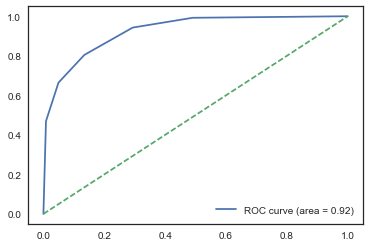

In [687]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % m)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()

In [688]:
knn.score(X_test, y_test)

0.76888888888888884

In [689]:
predictions = knn.predict(X_test)

print metrics.classification_report(y_test, predictions)

             precision    recall  f1-score   support

          0       0.74      0.81      0.77       436
          1       0.81      0.73      0.76       464

avg / total       0.77      0.77      0.77       900



In [690]:
cmatrix = np.array(metrics.confusion_matrix(y_test, predictions, labels=[0,1]))

confusion = pd.DataFrame(cmatrix, index=['Is Low', 'Is High'],
                            columns=['Predict Low','Predict High'])
print confusion

         Predict Low  Predict High
Is Low           355            81
Is High          127           337


In [691]:
probabilities = knn.predict_proba(X_test)[:,1]

In [692]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, probabilities, pos_label=1)

In [693]:
m = metrics.auc(fpr, tpr)
m

0.84110546504270811

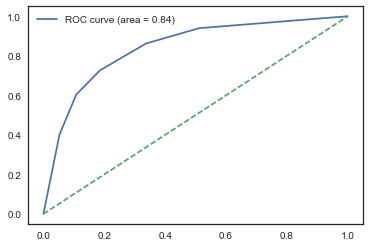

In [695]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % m)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()

In [742]:
#fit over entire dataframe
y = dfsqft['ishigh']
knn.fit(standardized_x,y)
knn.score(standardized_x,y)

0.82388258839226147

In [743]:
predictionfinal = knn.predict(standardized_x)
print metrics.classification_report(y, predictionfinal)

             precision    recall  f1-score   support

          0       0.83      0.81      0.82      1507
          1       0.81      0.84      0.83      1491

avg / total       0.82      0.82      0.82      2998



In [744]:
cmatrixfinal = np.array(metrics.confusion_matrix(y, predictionfinal, labels=[0,1]))

confusionfinal = pd.DataFrame(cmatrixfinal, index=['Is Low', 'Is High'],
                            columns=['Predict Low','Predict High'])
print confusionfinal

         Predict Low  Predict High
Is Low          1224           283
Is High          245          1246


In [745]:
probabilitiesfinal = knn.predict_proba(standardized_x)[:,1]

In [746]:
fpr, tpr, thresholds = metrics.roc_curve(y, probabilitiesfinal, pos_label=1)

In [747]:
mfinal = metrics.auc(fpr, tpr)
mfinal

0.91217933569120979

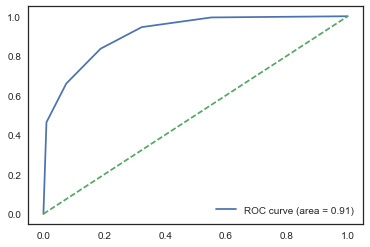

In [749]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % mfinal)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()

In [705]:
#Now we will do a run with dfnosqrt
dfnosqft['price'].describe()

count               3,810.00
mean              489,139.01
std               787,327.39
min                 5,000.00
25%               169,000.00
50%               299,900.00
75%               525,000.00
max            12,950,000.00
Name: price, dtype: float64

In [ ]:
#We will use the median as the split between 'high' and 'low' prices, since there a large values that bring the mean up

In [706]:
dfnosqft['ishigh'] = dfnosqft['price'].apply(lambda x: 1 if x > 299900 else 0)

In [707]:
dfnosqft['ishigh'].value_counts()

0    1911
1    1899
Name: ishigh, dtype: int64

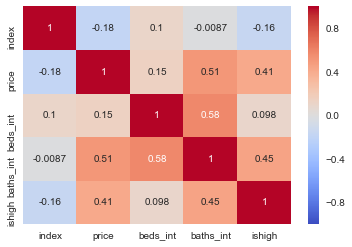

In [709]:
sns.heatmap(dfnosqft.corr(), cmap = 'coolwarm', annot = True)

In [713]:
features = ['beds_int','baths_int']
y = dfnosqft['ishigh']
log_reg1 = LogisticRegression()
hyperparameters = {'penalty':['l1','l2'],
                  'C': [0.1, 1.0, 10]}
grid_search1 = GridSearchCV(log_reg1, hyperparameters, verbose = 10)
grid_search1.fit(dfnosqft[features], y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.660630, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.726772, total=   0.0s
[CV] penalty=l1, C=0.1 ...............................................
[CV] ................ penalty=l1, C=0.1, score=0.727559, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.660630, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.726772, total=   0.0s
[CV] penalty=l2, C=0.1 ...............................................
[CV] ................ penalty=l2, C=0.1, score=0.727559, total=   0.0s
[CV] penalty=l1, C=1.0 ...............................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV] ................. penalty=l2, C=10, score=0.660630, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.726772, total=   0.0s
[CV] penalty=l2, C=10 ................................................
[CV] ................. penalty=l2, C=10, score=0.727559, total=   0.0s


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1.0, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [714]:
grid_search1.best_estimator_.fit(dfnosqft[features],y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [715]:
grid_search1.best_estimator_.score(dfnosqft[features],y)

0.74934383202099741

In [716]:
predictions1 = grid_search1.best_estimator_.predict(dfnosqft[features])

In [717]:
print metrics.classification_report(y, predictions1)

             precision    recall  f1-score   support

          0       0.75      0.75      0.75      1911
          1       0.75      0.75      0.75      1899

avg / total       0.75      0.75      0.75      3810



In [718]:
print pd.DataFrame(metrics.confusion_matrix(y, predictions1), 
                   columns=['Predicted Low', 'Predicted High'],
                   index=['Is Low', 'Is High'])

         Predicted Low  Predicted High
Is Low            1430             481
Is High            474            1425


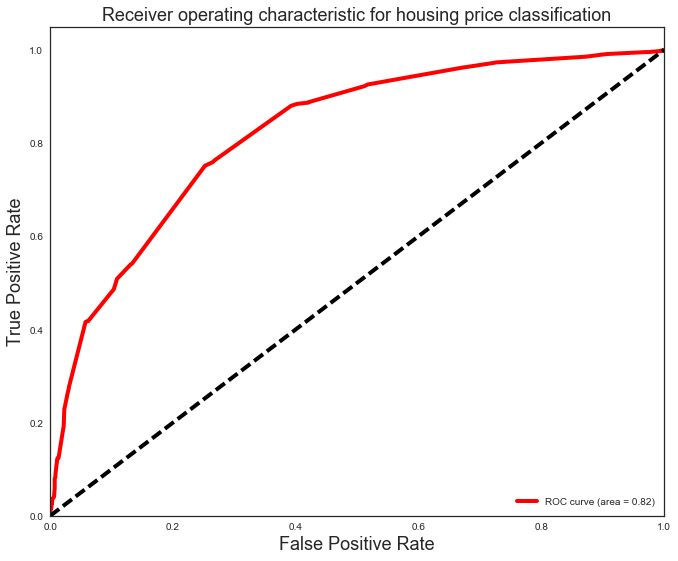

In [720]:
plt.style.use('seaborn-white')

Y_score1 = grid_search1.best_estimator_.decision_function(dfnosqft[features])

FPR = dict()
TPR = dict()
ROC_AUC = dict() # {}

# For class 1, find the area under the curve

#print metrics.roc_curve(y, Y_score)

FPR[1], TPR[1], _ = metrics.roc_curve(y, Y_score1)
ROC_AUC[1] = metrics.auc(FPR[1], TPR[1])


# Plot of a ROC curve for class 1 (high price)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4, color = 'r')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for housing price classification', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [721]:
x1 = dfnosqft[features]
standard_scale1 = StandardScaler()
standard_scale1.fit(x1)
standardized_x1 = standard_scale1.transform(x1)

In [722]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(standardized_x1, y, test_size = 0.3)

In [723]:
knn1 = KNeighborsClassifier()
knn1.fit(X_train1,y_train1)
knn1.score(X_train1,y_train1)

0.75590551181102361

In [724]:
predictions1 = knn1.predict(X_train1)
print metrics.classification_report(y_train1, predictions1)

             precision    recall  f1-score   support

          0       0.76      0.75      0.75      1327
          1       0.75      0.76      0.76      1340

avg / total       0.76      0.76      0.76      2667



In [725]:
cmatrix1 = np.array(metrics.confusion_matrix(y_train1, predictions1, labels=[0,1]))

confusion1 = pd.DataFrame(cmatrix1, index=['Is Low', 'Is High'],
                            columns=['Predict Low','Predict High'])
print confusion1

         Predict Low  Predict High
Is Low           995           332
Is High          319          1021


In [726]:
probabilities1 = knn1.predict_proba(X_train1)[:,1]

In [727]:
fpr, tpr, thresholds = metrics.roc_curve(y_train1, probabilities1, pos_label=1)

In [728]:
m1 = metrics.auc(fpr, tpr)
m1

0.80986008165652534

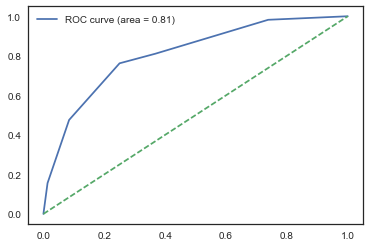

In [729]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % m1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()

In [730]:
knn1.score(X_test1, y_test1)

0.74015748031496065

In [731]:
probabilities2 = knn1.predict_proba(X_test1)[:,1]

In [732]:
fpr, tpr, thresholds = metrics.roc_curve(y_test1, probabilities2, pos_label=1)

In [733]:
m2 = metrics.auc(fpr, tpr)
m2

0.78570006371455881

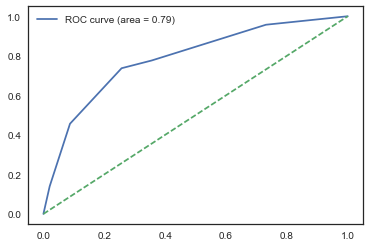

In [734]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % m2)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()

In [735]:
#We can see that the dataset with square feet included showed better scores, and we will select the k Nearest 
#Neighbors model as it fared better than the Logistic Regression. Additional details to be elaborated on in the 
#Executive Summary

**The code below shows the additional data I could have scraped on each individual listing. However, due to the time spent working on the original scraping code above, as well as cleaning the data, I did not have time to incorporate the data below. The data below would have allowed for more features to be included for model testing. Unfortunately, the variance in the structure and availability of the data that could be scraped with the code below would require a lot more time to clean and organize until they can be incorporated into the completed dataframes.**

In [738]:
website = 'http://www.zillow.com/homedetails/360-E-Randolph-St-601-602-Chicago-IL-60601/2095099011_zpid/'

r = requests.get(website)

with open('chicago_houses.html', 'w') as f:
    f.write(r.content)

with open('chicago_houses.html', 'r') as f:
    soup = BeautifulSoup(f,'lxml')
    

**The commented section is a loop that will retrieve every link in the 'more_info' column and make it the requested site so that it can be scraped with Beautiful Soup. For demonstration purposes, I am only printing out what the data of one listing contained. Additional features that could have been used were: Type of property, Year Built, days listed on Zillow, views on Zillow, specified agent for the listing.**

In [739]:
# for i, link in enumerate(df['more_info']):
#     website = '"' + link + '"'
#     r = requests.get(website)
#     soup = BeautifulSoup(r.content, 'lxml')
#     yrb = {}
facts = soup.find('div',{'class':'fact-group-container zsg-content-component top-facts'})
children = facts.findChildren()
for child in children:
    fact = child.find_all('li')
    for tag in fact:
        print tag.text


Baths: 3 full, 1 half
Condo
Built in 1982
11 days on Zillow
Views since listing: 833
All time views: 833
10 shoppers saved this home
Price/sqft: $481
MLS #: 09337885
Coldwell Banker Residential Brokera...
